In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import hashlib
import matplotlib.pyplot as plt

# Problem 1

In [2]:
mainPath = "C:\\Users\\nizhe\\Desktop\\ESE-545\\Projects\\P1\\Netflix_data.txt"

In [3]:
# Drop all the ratings that below 3
def dropRatingsBelow3 (original_df):
#     result_df = original_df[original_df['Rating'] > 3]
    result_df = original_df[(original_df['Rating'] != 1) & (original_df['Rating'] != 2)]
    return result_df

In [4]:
# Drop the users who still have more than 20 ratings
def dropUsersAbove20 (selected_df_0):
    users_df = selected_df_0.groupby('User_id').count().reset_index().rename(columns = {'Rating' : 'count'})
    users_df = users_df[users_df['count'] > 20]
    selected_df = selected_df_0.set_index('User_id').drop(list(users_df['User_id'])).reset_index()
    return selected_df

In [5]:
def mainP1(mainPath):
    
    # Read in file
    original_df = pd.read_csv(mainPath, names = ['User_id', 'Rating', 'Date']).drop('Date', axis = 1)
    
    # Those value == 100 are movie_id rows 
    original_df.fillna(value = 100, inplace = True)
    
    # drop <3 and >20
    selected_df_0 = dropRatingsBelow3(original_df)
    selected_df = dropUsersAbove20(selected_df_0) # those rows with Rating 100 is the movie_id
    
    # get total movie and user number
    movieNum = len(selected_df[selected_df['Rating'] == 100])
    users = list(selected_df[selected_df['Rating'] != 100].groupby('User_id').count().reset_index()['User_id'].astype(int))
    userNum = len(users)
    
    return selected_df, users, movieNum, userNum

In [6]:
def getMatrix(selected_df, users, movieNum, userNum):
    final = np.zeros((movieNum, userNum))
    movie_id = 0
    for index, row in selected_df.iterrows():
        if row['Rating'] == 100:
            movie_id += 1
            continue
        final[movie_id - 1, users.index(int(row['User_id']))] = 1
    
    return final

In [11]:
selected_df, users, movieNum, userNum = mainP1(mainPath)

NameError: name 'mainP1' is not defined

# Problem 2

In [1]:
# 备用过程

import numpy as np
import pandas as pd
import time
import datetime
import hashlib
import matplotlib.pyplot as plt

final = np.load('C:\\Users\\nizhe\\Desktop\\ESE-545\\Projects\\P1\\final.npy')

In [5]:
movieNum, userNum = 4499, 231424

In [2]:
def jaccardDistance(list1, list2):
    arr = np.array([list1, list2]).T
    union = len(arr[arr.sum(axis = 1) > 0])
    intersect = len(arr[arr.sum(axis = 1) == 2])
    
    return 1 - intersect / union

In [6]:
distance = []
for i in range(10000):
    a = np.random.randint(0,userNum)
    b = np.random.randint(0,userNum)

    list1 = final[:,a]
    list2 = final[:,b]

    distance.append(jaccardDistance(list1, list2))

Text(0,0.5,'Count')

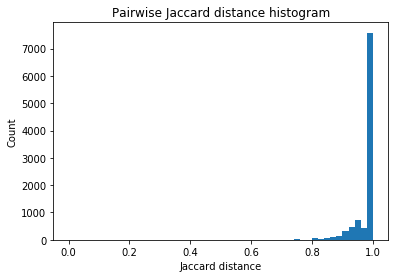

In [7]:
plt.hist(distance, bins= 50)  
plt.title("Pairwise Jaccard distance histogram")
plt.xlabel('Jaccard distance')
plt.ylabel('Count')

# Problem 3

In [8]:
hashNum = 60
nextPrime = 4507

In [9]:
def getSignatureMatrix(final, movieNum, userNum):
    
    # generate full np array as an initial signature matrix
    sig_mat = np.full((hashNum, userNum), movieNum + 1)
    
    # params for each hash function 
    hash_func = np.random.randint(0, nextPrime, (hashNum, 2))
    
    for i in range(len(users)):    
        for index in range(movieNum):
            if final[index,i] == 1:
                for j in range(0,hashNum):
                    sig_mat[j,i] = min((hash_func[j,0] * index + hash_func[j,1]) % movieNum, sig_mat[j,i])
                    
    return sig_mat

In [10]:
sig_mat = getSignatureMatrix(final, movieNum, userNum)

NameError: name 'users' is not defined

In [64]:
def getHashBuckets(sig_mat, r, userNum):
    # r is number of rows per band
    
    hashBuckets = []
    i = 0
    while i < (hashNum / r):
        bucket = {}  
        for j in range(0, userNum):
            hashobj = hashlib.md5()

            band = str(sig_mat[r*i: r*i + r, j])
            hashobj.update(band.encode())
            tag = int(hashobj.hexdigest(),16)

            
            if tag not in bucket:
                bucket[tag] = [(users[j], final[:, j])] 
                
#                 bucket[tag] = [users[j]]   
            else:
                
                bucket[tag].append((users[j], final[:, j]))
#                 bucket[tag].append(users[j])

        hashBuckets.append(bucket)
        i += 1
        
    return hashBuckets

In [65]:
hashBuckets = getHashBuckets(sig_mat, 4, userNum)

In [ ]:
pairs = set()
for i in hashBuckets:
    # i is a dict, {hash_value : [{user_id : array},{}]}
    
    for k in i.keys():
        
        if len(i[k]) == 1:
            continue
            
        for m in range(len(i[k])):
            # i[k] is a list, [{},{}]
            
            for n in range(m, len(i[k])):
                
                if jaccardDistance(i[k][m][1], i[k][n][1]) < 0.35:
                    
                    pairs.add((i[k][m][0],i[k][n][0]))            